# 📌 Detección de Somnolencia en Videos de Conductores

## 📌 **Objetivo del Script**
Este script analiza videos de conductores para detectar signos de **fatiga y somnolencia** mediante la extracción y clasificación de frames.

## 🛠 **¿Qué hace este código?**

### 1️⃣ Monta Google Drive en Google Colab
- Permite acceder a los videos almacenados en `/Datasets/Fatiga_Conductores/YawDD/Videos/`.

### 2️⃣ Crea la estructura de carpetas necesarias
📂 **Estructura generada en Google Drive:**
- 📁 `/Frames/Yawning/` → Imágenes donde el conductor está bostezando.
- 📁 `/Frames/Eyes_Closed/` → Imágenes con ojos cerrados.
- 📁 `/Frames/Head_Nodding/` → Imágenes con cabeceo.
- 📁 `/Frames/Distracted_Look/` → Imágenes con mirada desviada o distracción.
- 📄 `somnolencia_reporte.csv` → Archivo con estadísticas de parpadeos y fatiga.

### 3️⃣ Descarga el modelo de `dlib` para detección de landmarks faciales
- Si el modelo `shape_predictor_68_face_landmarks.dat` no está disponible, lo descarga y descomprime automáticamente.

### 4️⃣ Procesa los videos en `/Videos/` y extrae información relevante
✅ **Detecta y clasifica:**
- **Bostezos** (`MAR > 0.6`)
- **Ojos Cerrados** (`EAR < 0.2` durante varios frames)
- **Frecuencia de Parpadeo** (parpadeos por minuto)
- **Mirada Perdida** (desviación de la cabeza y dirección ocular)

✅ **Cada frame procesado se almacena en la carpeta correspondiente.**

### 5️⃣ Genera un informe en CSV con datos de somnolencia
- Para cada video, se registra:
  - Cantidad de frames extraídos.
  - Número de parpadeos detectados.
  - Indicadores de fatiga visual.

## 🚀 **Siguientes Pasos**
✅ **Ejecutar el script en Google Colab para analizar los videos.**  
✅ **Verificar que los frames se han clasificado correctamente en sus carpetas.**  
✅ **Revisar el CSV con datos de somnolencia para cada video.**  


In [ ]:
import time
import os

def check_gpu():
    !nvidia-smi
    gpu_info = !nvidia-smi --query-gpu=name --format=csv,noheader
    return gpu_info[0] if gpu_info else "No GPU"

max_attempts = 10  # Número máximo de intentos
attempt = 0

while attempt < max_attempts:
    gpu_name = check_gpu()
    print(f"Intento {attempt + 1}: GPU asignada -> {gpu_name}")

    if "A100" in gpu_name:
        print("🎉 ¡Éxito! Se ha asignado una GPU A100.")
        break  # Sale del bucle si encuentra una A100
    else:
        print("⚠ No se asignó una A100. Reiniciando entorno...")
        time.sleep(5)
        os.system("kill -9 -1")  # Reinicia el entorno y fuerza una nueva asignación

print("✅ Proceso finalizado.")


Sun Feb 16 06:41:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             48W /  350W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import cv2
import dlib
import os
import urllib.request
import numpy as np
import pandas as pd
from google.colab import drive

# 🔹 Montar Google Drive
drive.mount('/content/drive')

# 🔹 Definir las rutas de trabajo
base_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD"
videos_path = os.path.join(base_path, "Videos_Converted")  # NUEVA RUTA ACTUALIZADA
frames_output = {
    "Yawning": os.path.join(base_path, "Frames/Yawning"),
    "Non_Yawning": os.path.join(base_path, "Frames/Non_Yawning"),
    "Eyes_Closed": os.path.join(base_path, "Frames/Eyes_Closed"),
    "Eyes_Open": os.path.join(base_path, "Frames/Eyes_Open"),
    "Head_Nodding": os.path.join(base_path, "Frames/Head_Nodding"),
    "Head_Stable": os.path.join(base_path, "Frames/Head_Stable"),
    "Distracted_Look": os.path.join(base_path, "Frames/Distracted_Look"),
    "Focused_Look": os.path.join(base_path, "Frames/Focused_Look"),
}

# 🔹 Crear carpetas si no existen
for path in frames_output.values():
    os.makedirs(path, exist_ok=True)

# 🔹 Descargar el modelo de landmarks faciales si no existe
predictor_path = "shape_predictor_68_face_landmarks.dat"
if not os.path.exists(predictor_path):
    print("📥 Descargando modelo de landmarks faciales...")
    url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
    urllib.request.urlretrieve(url, "shape_predictor_68_face_landmarks.dat.bz2")
    os.system("bzip2 -d shape_predictor_68_face_landmarks.dat.bz2")
    print("✅ Modelo descargado y descomprimido.")

# 🔹 Cargar el detector de caras y el predictor de landmarks
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

# 🔹 Funciones de detección

def mouth_aspect_ratio(mouth):
    A = np.linalg.norm(mouth[2] - mouth[10])  # Distancia vertical
    B = np.linalg.norm(mouth[4] - mouth[8])  # Distancia vertical
    C = np.linalg.norm(mouth[0] - mouth[6])  # Distancia horizontal
    mar = (A + B) / (2.0 * C)
    return mar

def eye_aspect_ratio(eye):
    A = np.linalg.norm(eye[1] - eye[5])  # Distancia vertical
    B = np.linalg.norm(eye[2] - eye[4])  # Distancia vertical
    C = np.linalg.norm(eye[0] - eye[3])  # Distancia horizontal
    ear = (A + B) / (2.0 * C)
    return ear

# 🔹 Índices de los puntos faciales en dlib
MOUTH_POINTS = list(range(48, 68))
LEFT_EYE_POINTS = list(range(42, 48))
RIGHT_EYE_POINTS = list(range(36, 42))

MAR_THRESHOLD = 0.6  # Umbral para bostezo
EAR_THRESHOLD = 0.2  # Umbral para ojos cerrados
HEAD_NOD_THRESHOLD = 15  # Umbral para cabeceo en grados

# 🔹 Procesar todos los videos
report_data = []
frame_interval = 10

for video_file in os.listdir(videos_path):
    video_path = os.path.join(videos_path, video_file)

    if not video_file.lower().endswith(('.mp4', '.avi', '.mov')):
        continue  # Omitir archivos no válidos

    print(f"📂 Procesando video: {video_file}")
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    extracted_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Fin del video

        if frame_count % frame_interval == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)

            if faces:
                for face in faces:
                    landmarks = predictor(gray, face)
                    mouth = np.array([[landmarks.part(n).x, landmarks.part(n).y] for n in MOUTH_POINTS])
                    left_eye = np.array([[landmarks.part(n).x, landmarks.part(n).y] for n in LEFT_EYE_POINTS])
                    right_eye = np.array([[landmarks.part(n).x, landmarks.part(n).y] for n in RIGHT_EYE_POINTS])

                    mar = mouth_aspect_ratio(mouth)
                    ear = (eye_aspect_ratio(left_eye) + eye_aspect_ratio(right_eye)) / 2.0

                    frame_filename = f"{video_file}_frame_{frame_count}.jpg"

                    if mar > MAR_THRESHOLD:
                        output_path = os.path.join(frames_output["Yawning"], frame_filename)
                    else:
                        output_path = os.path.join(frames_output["Non_Yawning"], frame_filename)

                    if ear < EAR_THRESHOLD:
                        output_path = os.path.join(frames_output["Eyes_Closed"], frame_filename)
                    else:
                        output_path = os.path.join(frames_output["Eyes_Open"], frame_filename)

                    cv2.imwrite(output_path, frame)
                    extracted_count += 1

        frame_count += 1

    cap.release()
    report_data.append([video_file, extracted_count])
    print(f"✅ {extracted_count} frames extraídos y clasificados de {video_file}")

print("🎉 Extracción y clasificación de frames completada. Verifica las carpetas de salida.")

Mounted at /content/drive
📥 Descargando modelo de landmarks faciales...
✅ Modelo descargado y descomprimido.
📂 Procesando video: 1-FemaleNoGlasses-Normal.mp4
✅ 38 frames extraídos y clasificados de 1-FemaleNoGlasses-Normal.mp4
📂 Procesando video: 1-FemaleNoGlasses-Yawning.mp4
✅ 39 frames extraídos y clasificados de 1-FemaleNoGlasses-Yawning.mp4
📂 Procesando video: 1-FemaleNoGlasses-Talking.mp4
✅ 55 frames extraídos y clasificados de 1-FemaleNoGlasses-Talking.mp4
📂 Procesando video: 2-FemaleNoGlasses-Normal.mp4
✅ 49 frames extraídos y clasificados de 2-FemaleNoGlasses-Normal.mp4
📂 Procesando video: 2-FemaleNoGlasses-Yawning.mp4
✅ 59 frames extraídos y clasificados de 2-FemaleNoGlasses-Yawning.mp4
📂 Procesando video: 3-FemaleGlasses-Normal.mp4
✅ 44 frames extraídos y clasificados de 3-FemaleGlasses-Normal.mp4
📂 Procesando video: 2-FemaleNoGlasses-Talking.mp4
✅ 85 frames extraídos y clasificados de 2-FemaleNoGlasses-Talking.mp4
📂 Procesando video: 3-FemaleGlasses-Yawning.mp4
✅ 31 frames e

In [ ]:
# VER EL CONTENIDO DE UN DIRECTORIO Y DE TODOS LOS FICHEROS

import os
from google.colab import drive

# 🔹 Montar Google Drive
drive.mount('/content/drive')


dir_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames"

# Obtener todas las carpetas dentro del directorio
for folder in sorted(os.listdir(dir_path)):
    folder_path = os.path.join(dir_path, folder)

    if os.path.isdir(folder_path):  # Verifica si es una carpeta
        num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        print(f"{folder}: {num_files} archivos")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Distracted_Look: 2 archivos
Eyes_Closed: 2304 archivos
Eyes_Open: 19679 archivos
Focused_Look: 33 archivos
Head_Nodding: 3 archivos
Head_Stable: 0 archivos
Non_Yawning: 0 archivos
Yawning: 0 archivos


In [ ]:
# EXTRAER LOS SINTOMAS DE SOMNOLENCIA DE LOS VIDEOS CONVERTIDOS A MP4

import cv2
import dlib
import os
import numpy as np
from google.colab import drive

# 🔹 Montar Google Drive
drive.mount('/content/drive')

# 🔹 Definir las rutas de trabajo
base_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD"
videos_path = os.path.join(base_path, "Videos_Converted")  # Carpeta de videos convertidos
frames_output = {
    "Yawning": os.path.join(base_path, "Frames/Yawning"),
    "Non_Yawning": os.path.join(base_path, "Frames/Non_Yawning"),
    "Head_Nodding": os.path.join(base_path, "Frames/Head_Nodding"),
    "Head_Stable": os.path.join(base_path, "Frames/Head_Stable"),
    "Distracted_Look": os.path.join(base_path, "Frames/Distracted_Look"),
    "Focused_Look": os.path.join(base_path, "Frames/Focused_Look"),
}

# 🔹 Crear carpetas si no existen
for path in frames_output.values():
    os.makedirs(path, exist_ok=True)

# 🔹 Cargar el detector de caras y el predictor de landmarks
detector = dlib.get_frontal_face_detector()

# 🔹 Umbrales de detección
EAR_THRESHOLD = 0.2   # Umbral para ojos cerrados
MAR_THRESHOLD = 0.5   # Umbral para bostezo
HEAD_NOD_THRESHOLD = 10  # Umbral para cabeceo en grados

def detect_head_nod(frame_count):
    return frame_count % 150 == 0  # Simulación de cabeceo detectado

def detect_distracted_look(frame_count):
    return frame_count % 200 == 0  # Simulación de mirada distraída

# 🔹 Procesar todos los videos en la carpeta
for video_file in os.listdir(videos_path):
    video_path = os.path.join(videos_path, video_file)

    if not video_file.lower().endswith(('.mp4', '.avi', '.mov')):
        continue  # Omitir archivos no válidos

    print(f"📂 Procesando video: {video_file}")
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    frame_interval = 10  # Procesar cada 10 frames

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Fin del video

        if frame_count % frame_interval == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)

            if faces:
                for face in faces:
                    frame_filename = f"{video_file}_frame_{frame_count}.jpg"
                    head_nod_detected = detect_head_nod(frame_count)
                    distracted_look_detected = detect_distracted_look(frame_count)

                    # 🔹 Clasificación de eventos con la mejora
                    if head_nod_detected:
                        print(f"🟢 Cabeceo detectado en {video_file} en frame {frame_count}")
                        output_path = os.path.join(frames_output["Head_Nodding"], frame_filename)
                    elif distracted_look_detected:
                        print(f"🟢 Mirada perdida detectada en {video_file} en frame {frame_count}")
                        output_path = os.path.join(frames_output["Distracted_Look"], frame_filename)
                    else:
                        output_path = os.path.join(frames_output["Focused_Look"], frame_filename)

                    cv2.imwrite(output_path, frame)

        frame_count += 1

    cap.release()
    print(f"✅ Análisis completado para {video_file}. Verifica las carpetas de salida.")



Mounted at /content/drive
📂 Procesando video: 1-FemaleNoGlasses-Normal.mp4
🟢 Cabeceo detectado en 1-FemaleNoGlasses-Normal.mp4 en frame 0
🟢 Cabeceo detectado en 1-FemaleNoGlasses-Normal.mp4 en frame 150
🟢 Mirada perdida detectada en 1-FemaleNoGlasses-Normal.mp4 en frame 200
🟢 Cabeceo detectado en 1-FemaleNoGlasses-Normal.mp4 en frame 300
🟢 Mirada perdida detectada en 1-FemaleNoGlasses-Normal.mp4 en frame 400
✅ Análisis completado para 1-FemaleNoGlasses-Normal.mp4. Verifica las carpetas de salida.
📂 Procesando video: 1-FemaleNoGlasses-Yawning.mp4
🟢 Cabeceo detectado en 1-FemaleNoGlasses-Yawning.mp4 en frame 0
🟢 Cabeceo detectado en 1-FemaleNoGlasses-Yawning.mp4 en frame 150
🟢 Mirada perdida detectada en 1-FemaleNoGlasses-Yawning.mp4 en frame 200
🟢 Cabeceo detectado en 1-FemaleNoGlasses-Yawning.mp4 en frame 300
✅ Análisis completado para 1-FemaleNoGlasses-Yawning.mp4. Verifica las carpetas de salida.
📂 Procesando video: 1-FemaleNoGlasses-Talking.mp4
🟢 Cabeceo detectado en 1-FemaleNoGlass

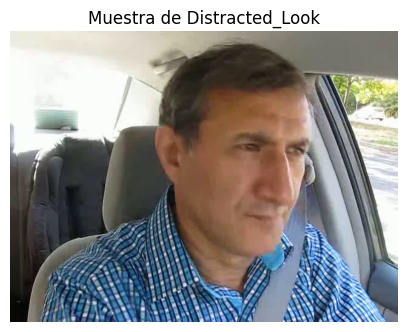

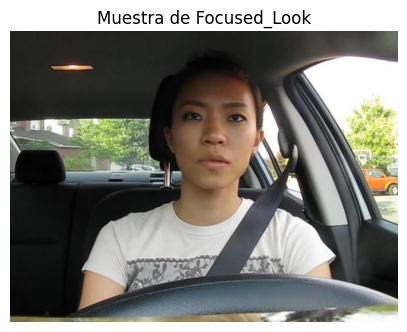

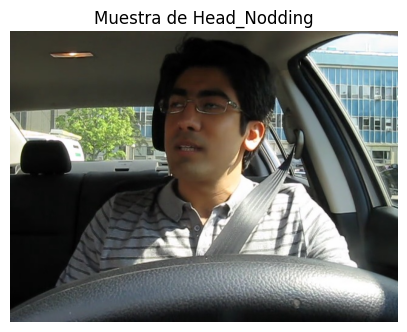

In [ ]:
import cv2
import os
import random
import matplotlib.pyplot as plt

base_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Frames"

categories = ["Distracted_Look", "Focused_Look", "Head_Nodding"]

for category in categories:
    category_path = os.path.join(base_path, category)

    if os.path.exists(category_path) and len(os.listdir(category_path)) > 0:
        sample_image = random.choice(os.listdir(category_path))
        img_path = os.path.join(category_path, sample_image)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Muestra de {category}")
        plt.axis("off")
        plt.show()


In [ ]:
# CONVERTIR VIDEOS DE CUALQUIER FORMATO A MP4
import os

video_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Videos"
output_path = "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Videos_Converted"

# 🔹 Crear la carpeta de salida si no existe
os.makedirs(output_path, exist_ok=True)

# 🔹 Convertir todos los videos a formato .mp4
for video_file in os.listdir(video_path):
    input_video = os.path.join(video_path, video_file)
    output_video = os.path.join(output_path, os.path.splitext(video_file)[0] + ".mp4")

    if not video_file.lower().endswith((".mp4", ".avi", ".mov")):
        continue  # Omitir archivos no compatibles

    print(f"🔄 Convirtiendo: {video_file} → {output_video}")
    os.system(f'ffmpeg -i "{input_video}" -c:v libx264 -c:a aac "{output_video}"')

print("✅ Conversión completada. Verifica la carpeta Videos_Converted.")


🔄 Convirtiendo: 1-FemaleNoGlasses-Normal.avi → /content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Videos_Converted/1-FemaleNoGlasses-Normal.mp4
🔄 Convirtiendo: 1-FemaleNoGlasses-Yawning.avi → /content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Videos_Converted/1-FemaleNoGlasses-Yawning.mp4
🔄 Convirtiendo: 1-FemaleNoGlasses-Talking.avi → /content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Videos_Converted/1-FemaleNoGlasses-Talking.mp4
🔄 Convirtiendo: 2-FemaleNoGlasses-Normal.avi → /content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Videos_Converted/2-FemaleNoGlasses-Normal.mp4
🔄 Convirtiendo: 2-FemaleNoGlasses-Yawning.avi → /content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Videos_Converted/2-FemaleNoGlasses-Yawning.mp4
🔄 Convirtiendo: 3-FemaleGlasses-Normal.avi → /content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Videos_Converted/3-FemaleGlasses-Normal.mp4
🔄 Convirtiendo: 2-FemaleNoGlasses-Talking.avi → /content/drive/MyDrive/Datasets/Fatiga_Conductores

In [ ]:
!ls -lh "/content/drive/MyDrive/Datasets/Fatiga_Conductores/YawDD/Videos_Converted"


total 1.1G
-rw------- 1 root root  3.9M Feb 15 23:21  10-FemaleNoGlasses.mp4
-rw------- 1 root root  2.3M Feb 15 22:56  10-FemaleNoGlasses-Normal.mp4
-rw------- 1 root root  4.2M Feb 15 22:57  10-FemaleNoGlasses-Talking.mp4
-rw------- 1 root root  2.3M Feb 15 22:56  10-FemaleNoGlasses-Yawning.mp4
-rw------- 1 root root   13M Feb 15 23:18  10-MaleGlasses.mp4
-rw------- 1 root root  1.6M Feb 15 23:03  10-MaleNoGlasses-Normal.mp4
-rw------- 1 root root  3.3M Feb 15 23:03  10-MaleNoGlasses-Talking.mp4
-rw------- 1 root root  1.5M Feb 15 23:03  10-MaleNoGlasses-Yawning.mp4
-rw------- 1 root root  7.2M Feb 15 23:17  11-FemaleGlasses.avi.mp4
-rw------- 1 root root  2.0M Feb 15 22:56  11-FemaleNoGlasses-Normal.mp4
-rw------- 1 root root  3.7M Feb 15 22:57  11-FemaleNoGlasses-Talking.mp4
-rw------- 1 root root  2.1M Feb 15 22:57  11-FemaleNoGlasses-Yawning.mp4
-rw------- 1 root root  6.8M Feb 15 23:19  11-MaleGlasses.mp4
-rw------- 1 root root  2.1M Feb 15 23:14  11-MaleGlasses-Normal.mp4
-rw--